## Active Learning: Simple illustration of the principles

In this exercise you will see the benefits of using active learning in a very simple setting. Imagine that we observe some data, $D = \{d_0, d_1, \dots, d_i\}$, on the domain $[0,1]$ with corresponding labels 0 or 1 depending on whether a point is below or above some (unknown) threshold, $\theta$. Let $x$ denote the value on the domain and $y$ the corresponding label such that $d_i = (x_i,y_i)$ with $x \in [0,1]$ and $y \in \{0,1\}$. This is also known as the "high-low" game and our objective will be to guess the threshold, $\theta$, by requesting labels for different values of $x$.

We shall assume that obtaining a label is "expensive" in some sense, hence limiting how many observations for which we can query a label. Our task is to determine which of the available observations we should query, i.e. get a label for, in order for a given learner to improve the most and consequently be able to guess the threshold as quickly as possible.

We will use a simple margin classifier which estimates the decision boundary as the threshold with the largest margin to both groups, i.e.,
$$
    \hat{\theta} = \max(X_0)+\frac{\min(X_1)-\max(X_0)}{2} = \frac{\max(X_0) + \min(X_1)}{2}
$$
where $X_k = \{x_i \mid (x_i,y_i) \in D, y_i = k \}$ indicates the set of points with label $k$. In words, we are simply choosing the threshold as the value which evenly divides the version space. Finally, to perform inference on a point, we shall just do a hard assignment of said point as either 0 or 1 depending on whether it is below or above the estimated threshold.

This problem is illustrated below with an increasing number of <font color=red>red points</font> and <font color=blue>blue points</font> being observations from the two different classes and the <font color=green>green dashed vertical line</font> is the unknown true threshold. The <font color=#ffe933>yellow dashed line</font> is the estimated threshold of our learner given the data. Notice that in the final drawing the additional data points do not improve the learner. Obviously if you sample infinite points, the learner should improve.

How do you classify the following problem setting using the scenario you have learned in the lecture?

<font color=lightblue>We can classify using membership query synthesis. This is due to the learners ability to ask for the label of any point in the 1D input space.</font>

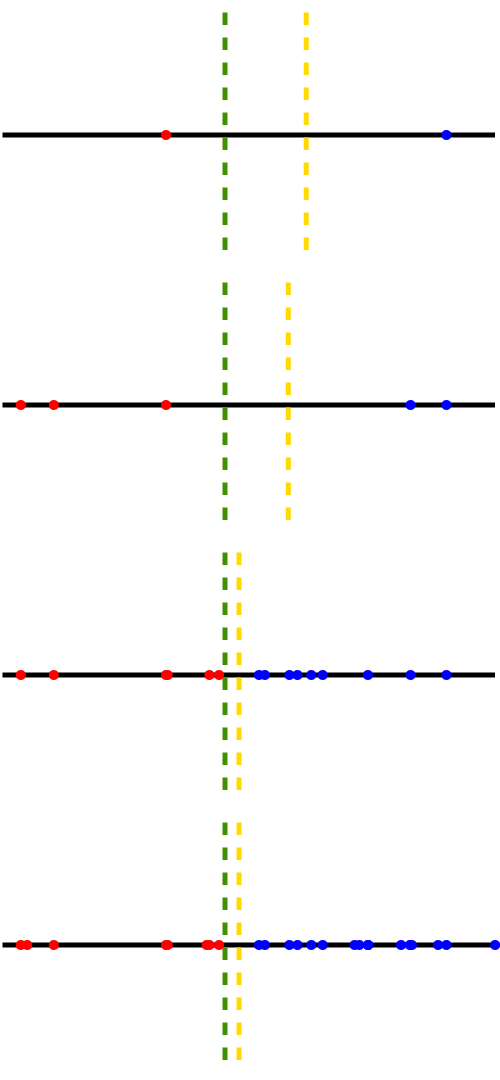

## Noiseless Labels
We will start by considering a scenario where there is no noise on the labels, i.e., the labels which we receive from the "oracle" are always correct. In this case, the likelihood of the label, $y_i$, is
$$
    p(d_i | \theta) =
    p(y_i, x_i | \theta) =
    \begin{cases}
            0 & x_i < \theta \oplus y_i = 0 \\ 
            1 & \text{otherwise} 
    \end{cases}
$$
where $\oplus$ denotes the "exclusive or" (`xor`) operator which evaluates to true only when one argument is true and the other is false, i.e., "when one or the other but not both and not neither". In this case, $x_i < \theta \oplus y_i = 0$ is true when $x_i$ is below the threshold and $y_i=1$ or when $x_i$ is above (or equal) to the threshold and $y_i=0$. These are the cases where the data point is *inconsistent* with the threshold. This simply means that if we know that a given point, $x_i$, has a label of 1, i.e., $d_i = (x_i, 1)$, then we can immediately discard all values of $\theta$ which are incompatible with this observation. (Please note that whether a point which perfectly coincides with the threshold (i.e., $x_i=\theta$) is assigned a label of 0 or 1 is arbitrary; we just need to be consistent.)

### Implementation
Below you will have to implement three learners each of which uses a different querying strategy.

1. `Learner1`. This learner (which really is not very bright!) simply queries points on the whole domain randomly. Strictly speaking, you probably would not consider this a learner as it does not use any of the available data to adjust its behavior.
2. `Learner2`. This learner queries points in the *version space* at random. This is better than the first learner in that it actually uses the information that becomes available to it to contrain the interval in which it guesses.
3. `Learner3`. This learner also only considers the version space when making queries, however, rather than simply choosing points at random within this space it tries to reduce it maximally each time (on average).

In the implementation below, each of these learners are a subclass of the `Learner` class meaning that they have access to all of its attributes and methods. You are required to implement a `query` method for each learner. Take a look at the definition of `Learner` to see how you can access the bounds of the domain and version space which you will need when implementing the different query strategies.

Once implemented, you can run an experiment using the `Experiment` class which takes a leaner as input and defines a `run` method which executes the experiment. Code for running the experiment is provided in the file `exercise_5_thresholding_utils.py` and is imported from there. Running an experiment performs the following steps until convergence (which means that the estimated threshold is "close enough" to the actual threshold).

1. Query learner for candidate point
2. Query oracle for corresponding label
3. Add data to learner and update version space
4. Terminate if converged, otherwise return to step 1

You are welcome to look through the code in `exercise_5_thresholding_utils.py` but it is not required to be able to perform the exercise. However, please note that `Oracle` returns `True` or `False` (rather that 1 or 0).

* For some of the learners, you will need to sample a random number in an interval. For this purpose you can use `self._rng`, specifically, `self._rng.uniform` which samples from a uniform distribution. `self._rng` is just an instance of `np.random.default_rng` - NumPy's default random number generator object. 

In [56]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

# This defines Experiment, PrababilisticExperiment, and some other stuff
from exercise_5_thresholding_utils import *

# plt.style.use('dark_background')

In [57]:
class Learner:
    def __init__(self):
        self._rng = np.random.default_rng()
        
        # lower and upper bounds on the domain
        self.domain_lb = 0
        self.domain_ub = 1
        
        # initial bounds on the version space
        self.version_space_lb = self.domain_lb
        self.version_space_ub = self.domain_ub
        
        # points which have been queried and their labels
        self.x = [] # points
        self.y = [] # labels

    def add_data(self, x, y):
        """Add data point and update version space accordingly. This is
        used by the Experiment class and you do not need to worry about it
        although it might be a good idea to make sure you understand *how* the
        version space bounds are updated."""
        self.x.append(x)
        self.y.append(y)
        if y:
            self.version_space_ub = min(self.version_space_ub, x)
        else:
            self.version_space_lb = max(self.version_space_lb, x)

#### Implement `Learner1`
This learner queries a *random* point on entire domain.

Converged using 586 samples
Estimated threshold   0.801
True threshold        0.804


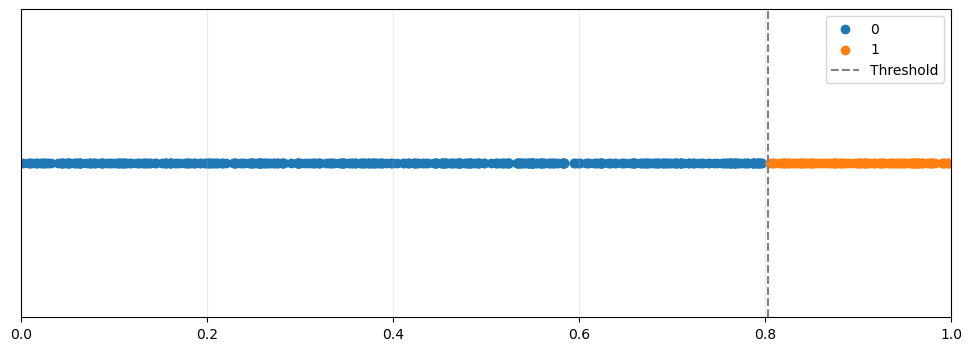

In [58]:
class Learner1(Learner):
    """A learner which queries randomly over the entire domain."""
    
    def query(self):
        """Returns the point (i.e., x) which we would like to have labeled."""
        # [your code here]
        return self._rng.uniform(self.domain_lb, self.domain_ub)
        

# Run an experiment to test the learner
learner = Learner1()
experiment = Experiment(learner)
nsamples = experiment.run()

#### Implement `Learner2`
This learner also queries a random point, however, only within the version space. Remind yourself what the version space is and check out the `add_data` method of `Learner` which automatically updates the version space each time a new observation is labeled and make sure you understand how the version space is updated.

Converged using 16 samples
Estimated threshold   0.385
True threshold        0.389


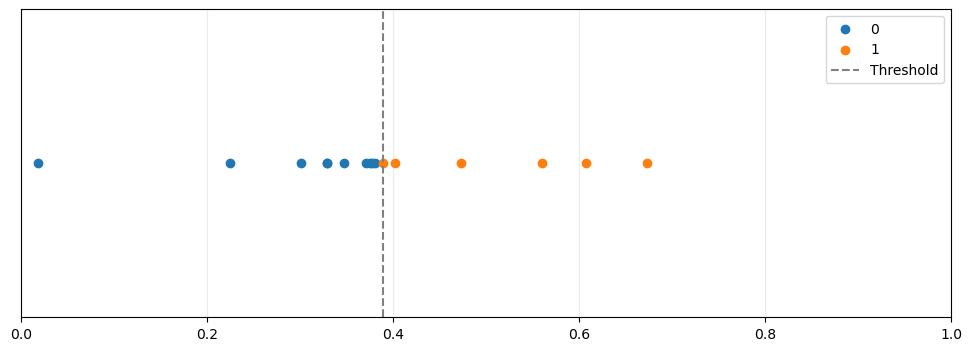

In [59]:
class Learner2(Learner):
    """A learner which queries randomly in the version space."""
    
    def query(self):
        """Returns the point (i.e., x) which we would like to have labeled."""
        # [your code here]
        return self._rng.uniform(self.version_space_lb, self.version_space_ub)


# Run an experiment to test the learner
learner = Learner2()
experiment = Experiment(learner)
nsamples = experiment.run()    

#### Implement `Learner3`
The last learner you implemented, was already using the information from the previous samples to reduce the space where we want to search. However, picking new data points at random is not always very efficient. The optimal strategy is one which reduces the version space maximally *on average*. Consider what would be the optimal strategy and implement it. 

[your answer here]

Converged using 7 samples
Estimated threshold   0.762
True threshold        0.760


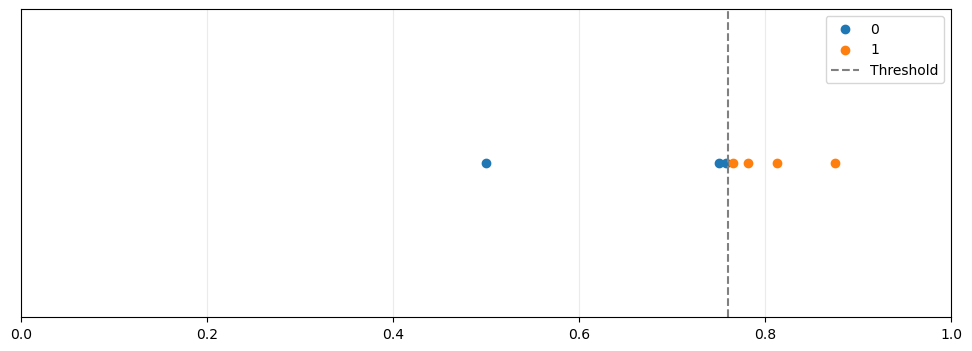

In [60]:
class Learner3(Learner):
    """A learner which queries so as to reduce the version space maximally each time."""
    
    def query(self):
        """Returns the point (i.e., x) which we would like to have labeled."""
        # [your code here]
        return (self.version_space_lb + self.version_space_ub)/2


# Run an experiment to test the learner
learner = Learner3()
experiment = Experiment(learner)
nsamples = experiment.run()

You can run an experiment without printing/plotting anything by using `verbose=False`, e.g., `Experiment(Learner1()).run(verbose=False)`. The `run` method will return the number of samples needed to converge. In particular, we consider a learner to have converged when the size of the version space is smaller than or equal to a selected tolerance level (by default we use 0.01). 

Using this we can run a lot of experiments (e.g., 10000) with each learner and make a histogram of the number of samples needed for convergence. Is this as you expected? In fact, you will not need to do any simulations for the leaner using the optimal strategy (`Learner3`). Why?

The Learner3 does not choose at random but rather learns on previous data, that is why we do not need to run any simulations.

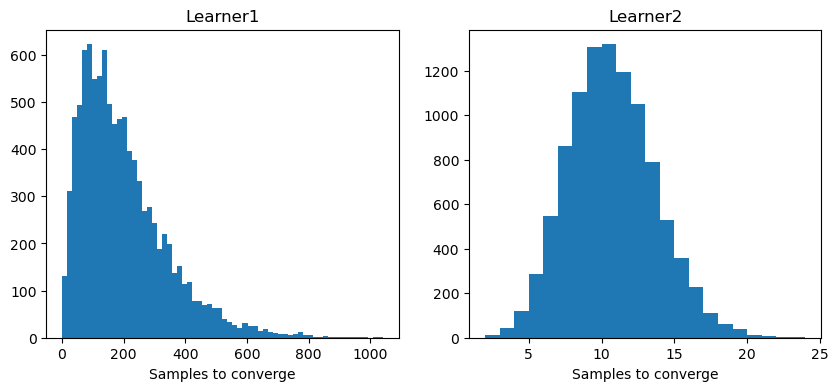

In [61]:
n_experiments = 10000

n = {k: [Experiment(learner()).run(verbose=False) for _ in range(n_experiments)] for k, learner in zip(('Learner1', 'Learner2'), (Learner1, Learner2))}

fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, k in zip(axes, n):
    ax.hist(n[k], 'auto')
    ax.set_title(k)
    ax.set_xlabel('Samples to converge')

## Noisy Labels
In this section we will extend our analysis to include noisy labels meaning that there is certain risk of a label being wrong. In order to handle this, we will need a probabilistic approach as described below. We start with a uniform prior on the value of the threshold, $p(\theta)$. Then, using some estimate of which point we believe would be most informative to have labeled, we query the oracle for a label and we update $p(\theta)$ so as to reflect his information. We repeat this a certain number of times until our "budget" is spent and we cannot afford to have any more points labeled.

### Updating the Posterior, $p(\theta | D)$
Let $\epsilon$ denote the probability that a label is wrong, i.e., the probability of the oracle lying (in the code, we call this `p_lie`). To handle this scenario, we will use a probabilistic model where we define the likelihood of observing a particular data point, $d_i=(x_i, y_i)$, as
$$
    p(d_i  | \theta) =
    p(y_i, x_i | \theta) =
    \begin{cases}
            \epsilon & x_i < \theta \oplus y_i = 0 \\ 
            1-\epsilon & \text{otherwise}.
    \end{cases}
$$
Importantly, and contrary to the noiseless setting, if we know that a given point, $x_i$, has a label of 1 so that $d_i = (x_i, 1)$, then we cannot completely discard all models which are incompatible with this observation since the label could be wrong.

Our initial beliefs about the threshold is captured in the prior, $p(\theta)$, which we shall take to be uniform, i.e., $p(\theta) \sim U(0,1)$. Once we have queried the oracle for the label associated with a given point, we would like to update our beliefs about $\theta$ so as to agree with our observation, i.e., want to compute the posterior probability of $\theta$. Say we have observed $d_i = (x_i, y_i)$, then we have
$$
        p(\theta | d_i) =\frac{p(d_i | \theta) p(\theta)}{p(d_i)}
$$
where the denominator (the evidence) is computed as
$$
        p(d_i) = \int_\theta p(d_i | \theta) p(\theta) d\theta.
$$
Once a new observation is added, we repeat the process; now we just use the posterior as the new prior. Consider the addition of the $i$th observation
$$
        p(\theta | d_i, D) =\frac{p(d_i | \theta, D) p(\theta | D)}{p(d_i | D)}
$$
where $D$ contains the previously observed data points.

### Calculating the Predictive Probabilities, $p(y | x, D)$
To be able to assess how uncertain we are about the label of a particular value of $x_i$, we need to compute the probability of obtaining $(x_i, y_i=0)$ and $(x_i, y_i=1)$ given the current state of our model. In a Bayesian setting, the predictive probability is given by
$$
    p(y_i | x_i, D) = \int_\theta p(y_i | \theta, x_i) p(\theta | D) d\theta
$$
where $p(\theta | D)$ is the posterior as calculated above. This computes the probability of a particular observation as the expectation over all possible models (thresholds). This is in contrast to the typical approach of using a point estimate of $\theta$ (e.g., a maximum likelihood estimate) for prediction as we are effectively integrating out the parameter.

As mentioned in the beginning, we perform inference by making hard assignments of the form
$$
    p(y_i | \theta, x_i) =
    \begin{cases}
            0 & x_i < \theta \oplus y_i=0 \\ 
            1 & \text{otherwise}.
    \end{cases}
$$
By combining these two expressions, you may be able to convince yourself that $p(y_i=1 | x_i, D)$ is nothing more than the integral of the posterior over all values of $\theta$ which agree with $(x_i, y_i=1)$. If you find it difficult to interpret the $\oplus$ operator, here is the above expression written out for the two cases of $y_i=0$ and $y_i=1$
\begin{align}
    p(y_i=1 | x_i, \theta) &=
    \begin{cases}
            0 & x_i < \theta \\ 
            1 & \text{otherwise}
    \end{cases} \\
    p(y_i=0 | x_i, \theta) &=
    \begin{cases}
            0 & x_i \geq \theta \\ 
            1 & \text{otherwise}.
    \end{cases}
\end{align}
Since we only have two possible labels these are obviously related as
\begin{align}
    p(y_i=0 | x_i, \theta) &= 1-p(y_i=1 | x_i, \theta).
\end{align}

### Selecting the Point to Query for a Label
Once we have computed $p(y_i=0 | x_i, \theta)$ and $p(y_i=1 | x_i, \theta)$ (the predictive probabilities) for all points of interest we are in a position to evaluate their uncertainty. In the first part we will use least confident and in the second part we will use expected entropy.

Implement the methods `update_posterior` and `compute_pred_prob` of `ProbabisticLearner`. The former updates the posterior and the latter calculates the predictive probabilities according to the formulas given above. You can use the methods `plot_posterior` and `plot_pred_prob` to visually inspect whether your implementation does as you would expect.

```
# check update_posterior
learner = ProbabilisticLearner()
fig, ax = plt.subplots()
learner.plot_posterior(ax)
learner.update_posterior(x=0.3, y=True, p_lie=0.1)
learner.plot_posterior(ax)

# check compute_pred_prob
learner = ProbabilisticLearner()
fig, ax = plt.subplots()
learner.plot_pred_prob(ax)
learner.update_posterior(x=0.3, y=True, p_lie=0.1)
learner.plot_pred_prob(ax)
```

In [62]:
class ProbabilisticLearner:
    def __init__(self, p_lie=0, domain_resolution=501):
        self.theta = DiscreteDomain([0,1], domain_resolution).points # cryptic way of doing np.linspace(0, 1, domain_resolution)
        self.p_theta = np.full_like(self.theta, 1/len(self.theta)) # the (uniform) prior
        # The points we have sampled
        self.x = []
        self.y = []

        
    def plot_posterior(self, ax=None, color=None):
        """Plot self.p_theta"""
        if ax is None:
            fig, ax = plt.subplots()
        return ax.plot(self.theta, self.p_theta, color=color)

    
    def plot_pred_prob(self, threshold=None):
        """Plot the result from self.compute_preb_prob()."""
        p_y0, p_y1 = self.compute_pred_prob().T
        fig, ax = plt.subplots()
        ax.plot(self.theta, p_y0)
        ax.plot(self.theta, p_y1)
        if threshold:
            ax.axvline(threshold, color="grey", linestyle="--")
        ax.legend(['p(y=0|x)', 'p(y=1|x)'])
        ax.set_xlabel('theta')
        ax.set_ylabel('p(y|x)')
        ax.set_title('Predictive Probabilities, p(y|x)')

        
    def plot_uncertainty(self, ax=None, color=None):
        """Can be used to plot `uncertainty`. Used when running an experiment.
        """
        if ax is None:
            fig, ax = plt.subplots()
        return ax.plot(self.theta, self.uncertainty, color=color)
    

    def update_posterior(self, x, y, p_lie, add_data=False):
        """This methods updates the posterior probabilities for each
        value of theta so as to reflect that we have observed the data point
        (x,y) at noise level `p_lie`. We use Bayes rule which, in words, states
        
            posterior = likelihood * prior / evidence

        - The prior is our current `p_theta`, i.e., our current beliefs about
          the distribution of the threshold.
        - The likelihood of observing a particular label given a value of x
          and a threshold.
        - The evidence just ensures that the posterier integrates (here sums)
          to one.

        This method should update `self.p_theta` (in place). (It should also
        add the data point to `self.x` and `self.y` but this is already
        implemented.)
        
        NOTES
        -----
        y as returned by the Oracle is either False or True (not 0 or 1)!
        
        HINTS
        -----
        * The likelihood depends on the value of x relative to theta and the
          value of y and is equal to either p_lie or 1-p_lie. Consider the
          following example:
              you observe (x=0.3, y=1) at p_lie=0.1. Is it more likely that
              the threshold is below 0.3 or above? Specifically, if we know
              that the oracle lies with probability 0.1 then we would get the
              current data point 9/10 times if the threshold is [above/below]
              and 1/10 times if the threshold is [above/below]. If this is
              tricky try to make a drawing or consider the "extreme" case where
              p_lie=0 (as in the previous exercises).
        * The purpose of the evidence is simply to ensure that the posterior
          normalizes to one, hence this part should be straightforward to
          implement.
        """
        if add_data:
            # keep track of what data points have been used to update the model
            self.x.append(x)
            self.y.append(y)

        # [your code here]
        # ^ means xor (exclusive or: (TRUE,FALSE), (FALSE,TRUE))
        agree = (self.theta < x) ^ (not y) if y else (self.theta <= x) ^ (not y)

        self.p_theta[agree] *= 1-p_lie
        self.p_theta[~agree] *= p_lie

        self.p_theta /= self.p_theta.sum()
        

    def compute_pred_prob(self):
        """This method returns the predictive probabilities, p(y|x), i.e., the
        our estimate of the probability of obtaining label 0 or 1 for each
        value of x (theta).
        
        This method should return an (n, 2) array where n = len(self.theta),
        i.e., is the number of models/thresholds. The first and second columns
        contain the probabilities of y=0 and y=1, respectively.
        
        HINTS
        -----
        * To compute this realize that, given a certain threshold, the
        probability of assigning a certain label, y, to a particular point, x,
        is either 0 or 1 depending on whether the x is above or below the 
        threshold.
        * Note that in the binary case, p(y=0|D) = 1-p(y=1|D).
        """
        # [your code here]
        p_y1 = self.p_theta.cumsum()
        return np.column_stack((1-p_y1, p_y1))


    def query_uncertainty(self):
        """This method returns the most uncertain point, i.e., the point
        we wish to request a label for, according to some criterion. It simply
        finds the maximum in the `uncertainty` attribute.
        """
        return self.theta[self.uncertainty.argmax()]

Implement `compute_uncertainty` of `LeastConfidentLearner`. 

In [63]:
class LeastConfidentLearner(ProbabilisticLearner):
    def __init__(self):
        super().__init__()
        self.name = "Least Confident"
        
    def compute_uncertainty(self):
        """This method computes the uncertainty of each point according to the
        least confident criterion. Please note that the result should be an
        *array* of len(self.theta) which is to be stored in `self.uncertainty`.
        
        When we run an experiment, the desired point is the queried using 
        `self.query_uncertainty` (already implemented) which simply chooses the
        point with the largest value (i.e., the least confident point).
        
        (The reason we want you to return the uncertainty of each point
        explicitly is so that we may plot it when we run an experiment.)
        """
        # [your code here]
        self.uncertainty = 1-self.compute_pred_prob().max(1)

Check your results by running an experiment for 20 iterations plotting all steps along the way. Finally, plot the predictive distribution along with the actual threshold. Code for this is provided in the cell below. You can also set `seed` for `ProbabilisticExperiment` which will make your results reproducible in terms of threshold and labels. Using `experiment.run(plot='all')` will run the experiment for 20 iterations and plot each state whereas `experiment.run(n=100)` will run the experiment for 100 iterations displaying only the final state. 

The markers at the top of the plots show the points which were sampled along with the label which was returned by the oracle (teal = 0, pink = 1). Try to run the experiment a few times and at different noise levels (`p_lie`). How the sampling is affected by wrongly labeled points? Does the model converge to the true threshold?

<font color=lightblue>The convergence is affected badly by the noise levels, but it seems to converge after many iterations.</font>

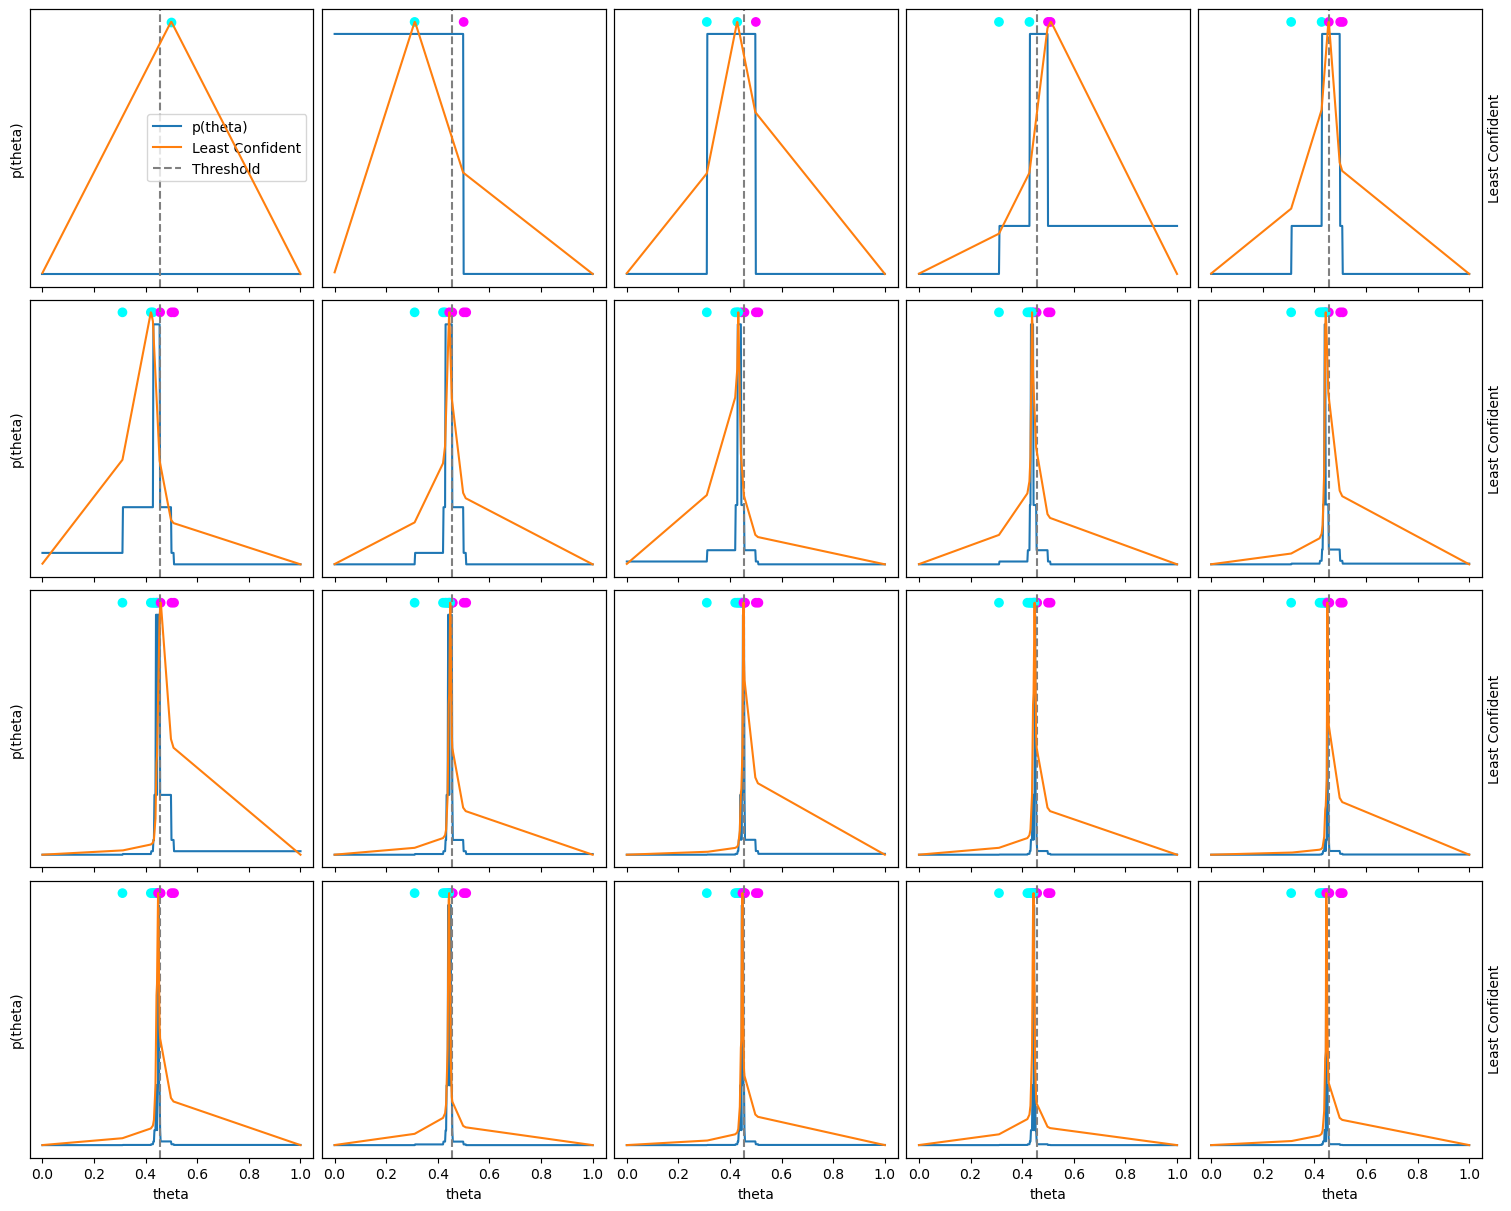

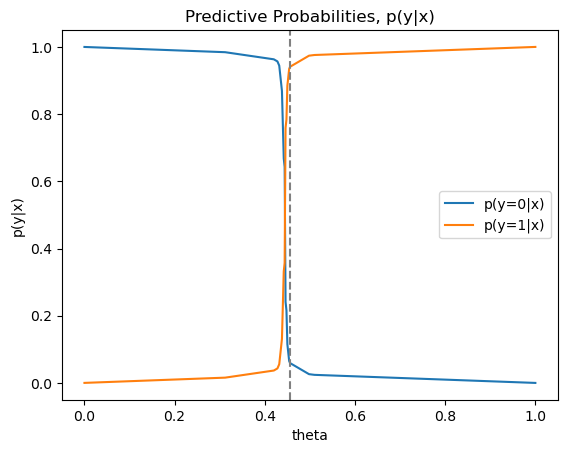

In [64]:
experiment = ProbabilisticExperiment(LeastConfidentLearner(), p_lie=0.2, seed=None) 
experiment.run(plot='all')
experiment.learner.plot_pred_prob(threshold=experiment.oracle.threshold)

Do the same but with many more iterations, `n`, and plot only the final result again considering different noise levels.

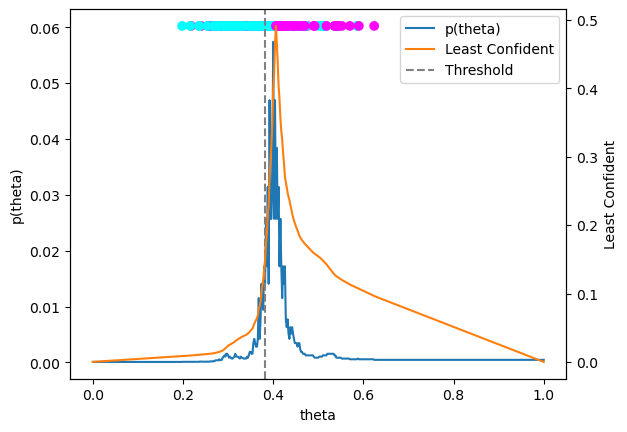

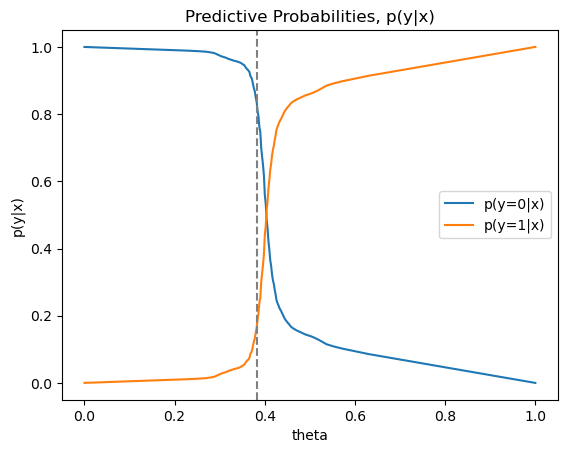

In [65]:
experiment = ProbabilisticExperiment(LeastConfidentLearner(), p_lie=0.45, seed=None)
experiment.run(n=1000)
experiment.learner.plot_pred_prob(threshold=experiment.oracle.threshold)

# Expected Error Reduction
<font color=red>This is a more advanced exercise so do the second exercise about uncertainty sampling in the iris dataset (exercise 6) first, then return to this exercise.</font>

Here we will extend the treatment above and look at expected error reduction. In particular, we will implement

\begin{align*}
    \phi_\text{eer}(x) &= -\sum_{y\in Y} P_{\theta}(y | x) \sum_{x^\prime \in U^\prime} \phi_\text{e}(x^\prime; \theta^\prime) \\
    &= \sum_{y\in Y} P_{\theta}(y | x) \sum_{x^\prime \in U^\prime} \sum_{y^\prime \in Y} P_{\theta^\prime}(y^\prime|x^\prime) \log P_{\theta^\prime}(y^\prime|x^\prime)
\end{align*}

which finds the value that minimizes the *expected entropy* of the predictive probabilities (however, keep in mind that we want to *maximize* the expression above!). $P_\theta(y | x)$ is the predictive probabilities wrt. the current model (posterior distribution) and $P_{\theta^\prime}(y | x)$ refers to the predictive probabilities obtained using a model which have been updated so as to include $(x,y)$. It is important to understand that $P_{\theta^\prime}(y | x)$ is the result of adding a *hypothetical* data point, $(x,y)$, i.e., it is the posterior we would get if we were to query the oracle with $x$ and we imagine that it gave us $y$.

In the lecture notes, $U$ contains all the points for which we do not have a label, however, here we will simply let $U$ contain *all* possible points (values of $\theta$) since a label might be wrong. $Y = \{0,1\}$ are the possible labels.

Try to see if you can parse the above expression and explain in words what we are calculating and what the point, $x^*$, denotes.

[your answer here]

If you think this looks like is a lot of computation you are completely right! We have to update the model for all combinations of data point and labels which is also why this is seldomly done in practice. It is important to understand that the concept of "model" here is simply the posterior of $p(\theta | D)$ (`p_theta` in the code).

Below we define a new learner called `ExpectedEntropyLearner`. Our goal is to implement a method, `compute_expected_entropy`, which finds $x^*$ using the expression above.

When computing the entropy you might find that you receive warnings because the probabilities are zero or perhaps even slightly negative (due to machine precision limits). You can use `np.nan_to_num` to handle NaNs returned by the logarithm function, however, you may find that you still get the warnings even though they are being handled by `np.nan_to_num`. You can disable warnings temporarily by for example
```
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # your calculations here
```

In [66]:
class ExpectedEntropyLearner(ProbabilisticLearner):
    def __init__(self):
        super().__init__()
        self.name = "Expected Entropy"
    
    def compute_expected_entropy(self, p_lie):
        """This method computes the negative expected entropy of the predictive
        probabilities and stores the result in `self.uncertainty`. It
        should be an array of len(self.theta). 
        
        (Again, the reason we want you to return the uncertainty of each point
        explicitly is so that we may plot it when we run an experiment.)
        
        HINTS
        -----
        * We need to compute entropy for all combinations of x (possible points
          to sample) and y (labels). For each such combination we need to update
          the posterior, calculcate the predictive probabilities, and compute
          the entropy. At the very end we need to take the expectation over
          entropies computed with different labels for each point.
        * Before updating the model, store the current state such that the
          updates with "hypothetical" data point can be easily undone, e.g.,          
          
            p_theta = self.p_theta.copy()
            # do stuff
            self.p_theta = p_theta.copy()
            
        * The expression inside the parenthesis can be computed without any
          need to loop explicitly since it is all calculated with the same
          model.
        (* By default, `add_data=False` of `self.update_posterior`. Leave it
          like that such that the hypothetical data points will not be added
          when you compute the entropy.)   
        """
        
        labels = (False, True)
        p_y = self.compute_pred_prob()
        H = np.zeros_like(self.compute_pred_prob()) # the entropy values
        p_theta = self.p_theta.copy() # to undo the update

        # [your code here]

Check your results by running an experiment for 20 iterations plotting all steps along the way. Finally, plot the predictive distribution along with the actual threshold. Try to vary `p_lie`.

Using the `seed` argument try to compare `LeastConfidentLearner` and `ExpectedEntropyLearner`. Do they seem to agree on the points to sample? How is this affected by the noise level (`p_lie`)? Can you explain this behavior?

[your answer here]

AttributeError: 'ExpectedEntropyLearner' object has no attribute 'uncertainty'

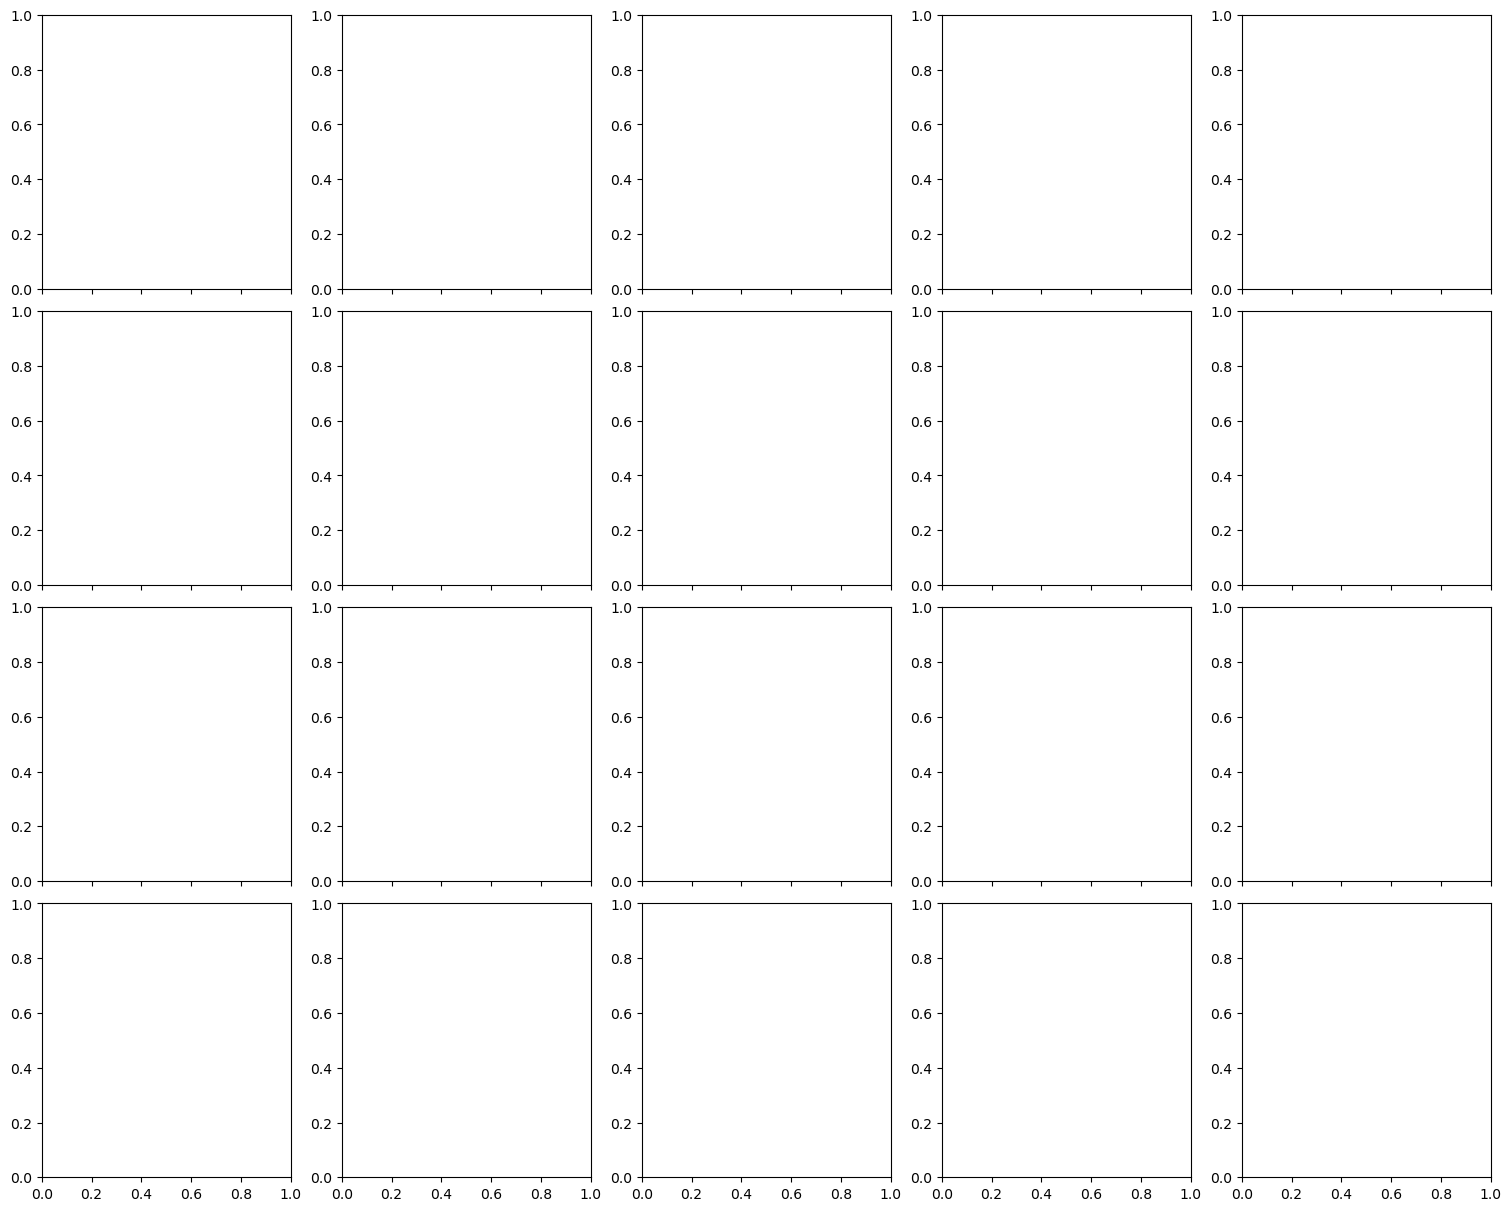

In [67]:
# low noise level
experiment = ProbabilisticExperiment(ExpectedEntropyLearner(), p_lie=0.2, seed=None)
experiment.run(plot='all')
experiment.learner.plot_pred_prob(threshold=experiment.oracle.threshold)

In [ ]:
# high noise level
experiment = ProbabilisticExperiment(ExpectedEntropyLearner(), p_lie=0.4, seed=None)
experiment.run(plot='all')
experiment.learner.plot_pred_prob(threshold=experiment.oracle.threshold)

Do the same but with more iterations, `n`, and plot only the final result.

In [ ]:
experiment = ProbabilisticExperiment(ExpectedEntropyLearner(), p_lie=0.4, seed=None)
experiment.run(n=100)
experiment.learner.plot_pred_prob(threshold=experiment.oracle.threshold)

Have a look at the `data` attribute of `ProbabilisticExperiment` which is a dictionary containing information about the entropy of the posterior (`entropy_posterior`) and the predictive probabilities (`entropy_pred_prob`). It also contains a field `label_wrong` which specifies whether the label obtained from the oracle was correct or not.

Here we look at the entropy of the predictive probabilities after adding a new point. How does this compare to the entropy of the posterior and predictive probabilities after sampling the point? Try to produce a plot showing the entropies as a function of samples obtained. How do correct/incorrect labels affect this? Is it consistent with your expectations?

[your answer here]

You may want to rescale the entropies to plot them together. Perhaps use a logarithmic scale. 

In [ ]:
# [your code here]